In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('financial_tweets_data.csv')

***EXPLORATORY PRE-PROCESSING***
--------------------------------

The Twitter Financial News dataset is an English-language dataset containing an annotated corpus of finance-related tweets. This dataset is used to classify finance-related tweets for their sentiment.

The dataset holds 11,932 documents annotated with 3 label
- Label_0 = BEARISH
- Label_1 = BULLISH
- Label_2 = NEUTRAL

**Licensing Information**
The Twitter Financial Dataset (sentiment) is released under the MIT Licensements:

**Source** - https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11931 entries, 0 to 11930
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11931 non-null  object
 1   label   11931 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 186.5+ KB


In [6]:
df.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [7]:
df.groupby('label').count()

,text
label,
0,1789
1,2398
2,7744


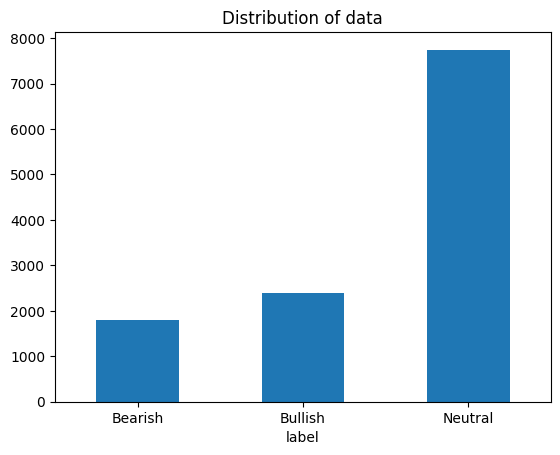

In [10]:
# Plotting the distribution for dataset.
ax = df.groupby('label').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Bearish','Bullish', 'Neutral'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['label'])

In [5]:
import re
def preprocess_text(text): 
    text = re.sub(r'$[A-Za-z]+', '', text)                                     #Remove dollar signs followed by letters
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)    #Remove URLs and www links
    text = re.sub(r'@\w+|#', '', text)                                         #Remove @mentions and hashtags
    text = text.lower()                                                        #Convert to lowercase
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)                                 #Remove non-alphanumeric characters and whitespace
    text = text.strip()                                                        #Remove leading and trailing whitespace
    return text

#Applying the function to a Pandas DataFrame
df['text']= df['text'].apply(preprocess_text)

In [17]:
df.head()

,text,label
0,bynd jpmorgan reels in expectations on beyond...,0
1,ccl rcl nomura points to bookings weakness at...,0
2,cx cemex cut at credit suisse jp morgan on we...,0
3,ess btig research cuts to neutral,0
4,fnko funko slides after piper jaffray pt cut,0


**Getting tokenization of tweet text**
-----

In [7]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\b\w+\b')              #r'\b\w+\b', matches whole words bounded by word boundaries (\b)
df['text'] = df['text'].apply(tokenizer.tokenize)
df['text'].head()

0    [bynd, jpmorgan, reels, in, expectations, on, ...
1    [ccl, rcl, nomura, points, to, bookings, weakn...
2    [cx, cemex, cut, at, credit, suisse, jp, morga...
3             [ess, btig, research, cuts, to, neutral]
4    [fnko, funko, slides, after, piper, jaffray, p...
Name: text, dtype: object

**Applying stemming**
---

In [9]:
import nltk

In [11]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
df['text']= df['text'].apply(lambda x: stemming_on_text(x))
df['text'].head()


0    [bynd, jpmorgan, reels, in, expectations, on, ...
1    [ccl, rcl, nomura, points, to, bookings, weakn...
2    [cx, cemex, cut, at, credit, suisse, jp, morga...
3             [ess, btig, research, cuts, to, neutral]
4    [fnko, funko, slides, after, piper, jaffray, p...
Name: text, dtype: object

**Applying lemmatizer**
----

In [13]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
df['text'] = df['text'].apply(lambda x: lemmatizer_on_text(x))
df['text'].head()

0    [bynd, jpmorgan, reels, in, expectations, on, ...
1    [ccl, rcl, nomura, points, to, bookings, weakn...
2    [cx, cemex, cut, at, credit, suisse, jp, morga...
3             [ess, btig, research, cuts, to, neutral]
4    [fnko, funko, slides, after, piper, jaffray, p...
Name: text, dtype: object

**Separating input feature and label**
---


In [15]:
X=df.text
y=df.label

**Plot a cloud of words for negative tweets**
---

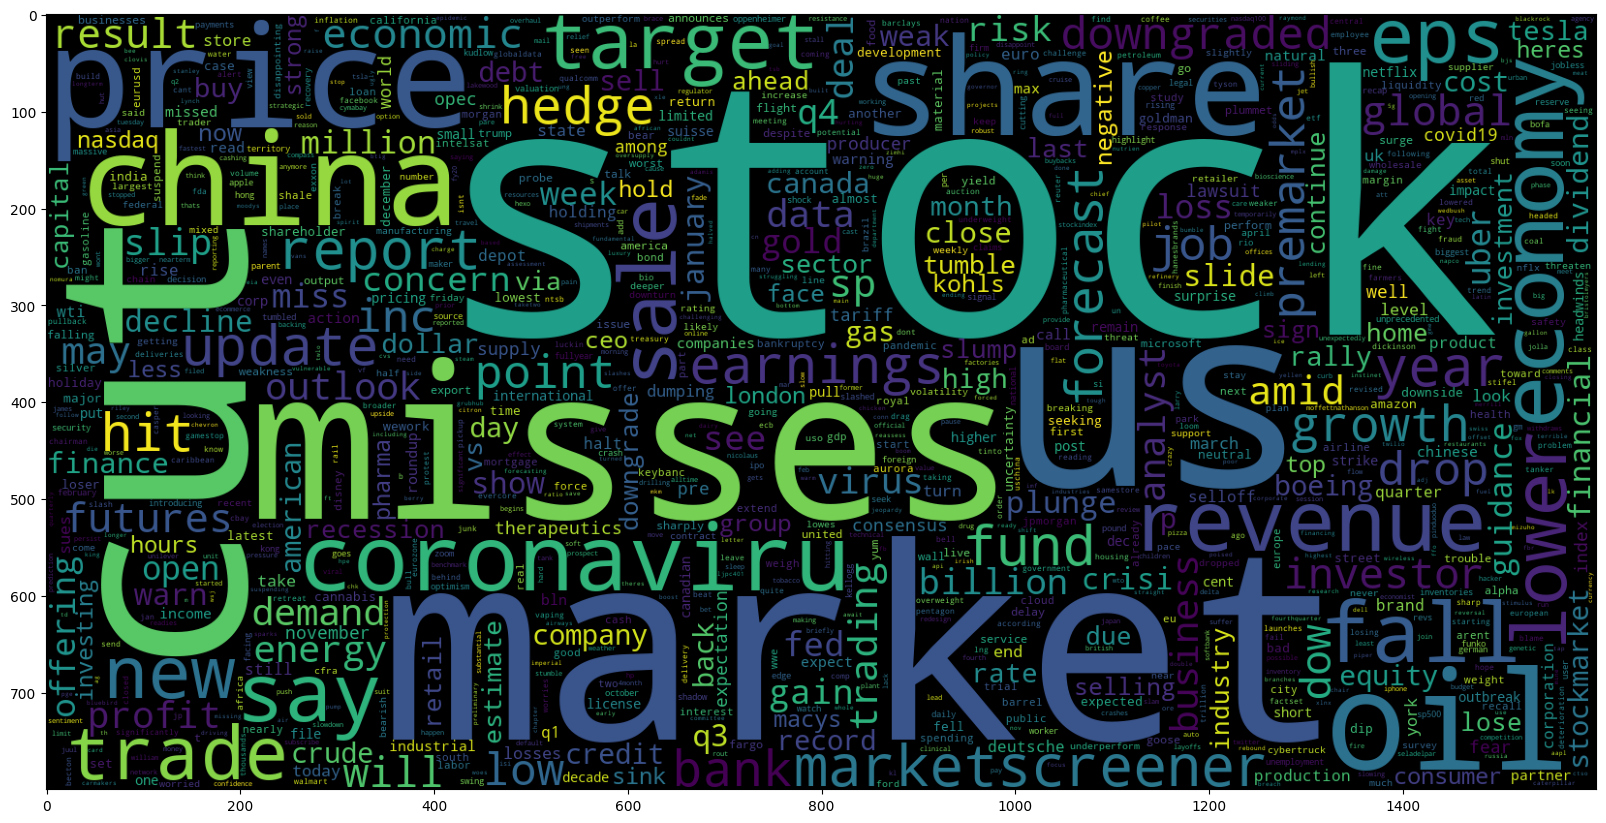

In [33]:
df_neg = df.loc[df['label'] == 0, 'text'][:11931]
words = " ".join([word for tokens in df_neg for word in tokens])
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(words)
plt.imshow(wc)

**Plot a cloud of words for positive tweets**
---

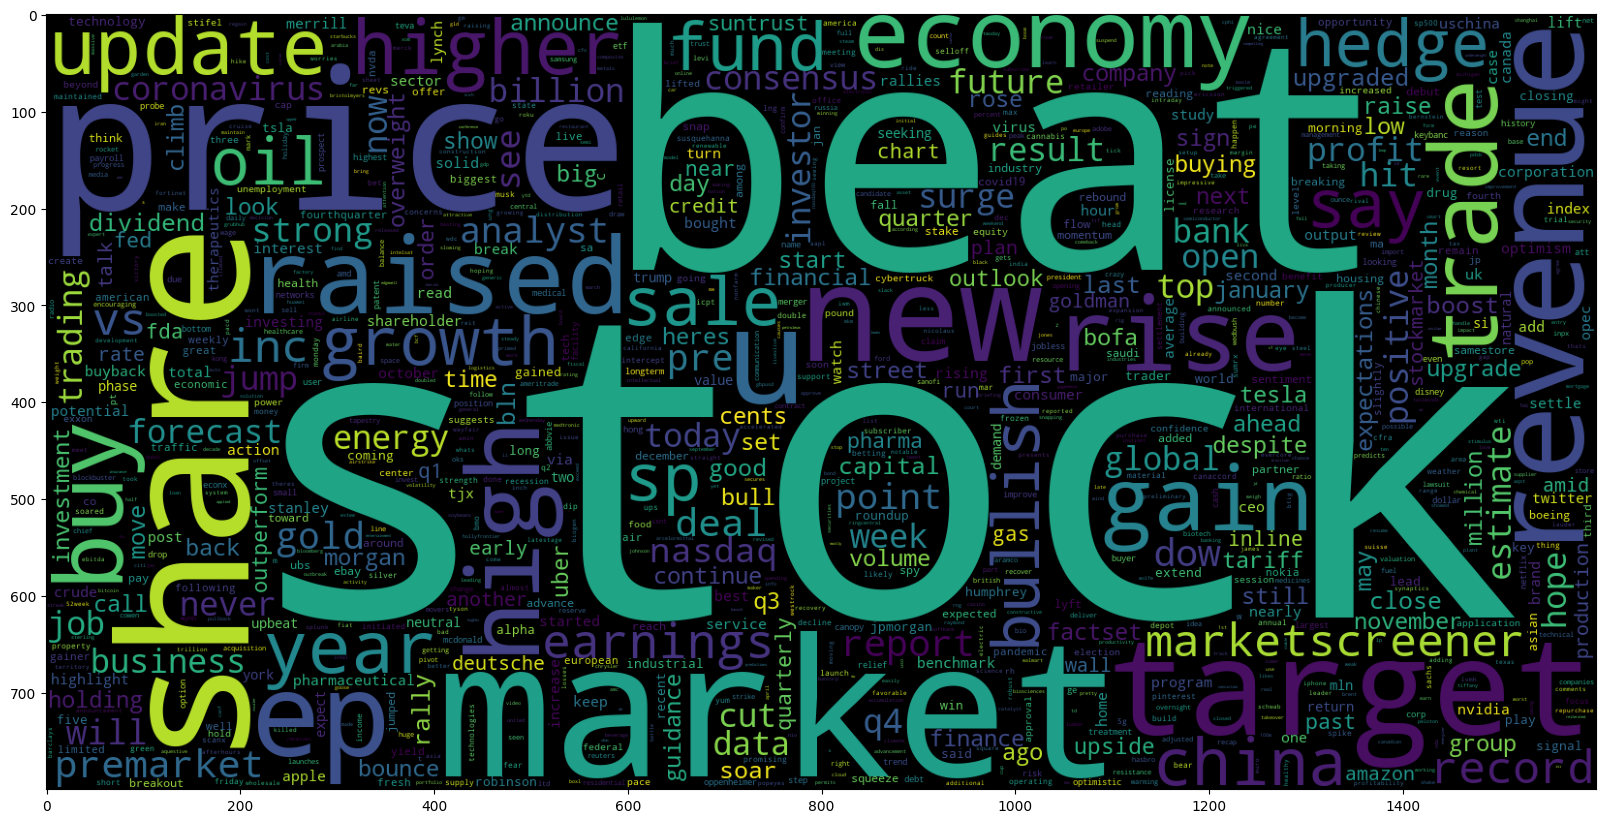

In [35]:
df_pos = df.loc[df['label'] == 1, 'text'][:11931]
pos_words = " ".join([word for tokens in df_pos for word in tokens])
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(pos_words)
plt.imshow(wc)

**Splitting Our Data Into Train and Test Subsets**
---

In [17]:
from sklearn.model_selection import train_test_split

In [19]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

**Transforming the Dataset Using TF-IDF Vectorizer**
--


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

In [23]:
X_train_flat = [' '.join(x) for x in X_train]
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train_flat)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  93360


**Transform the data using TF-IDF Vectorizer**

In [25]:
X_train_flat = [' '.join(x) for x in X_train]
X_test_flat = [' '.join(x) for x in X_test]

X_train_tfidf = vectoriser.transform(X_train_flat).toarray()
X_test_tfidf = vectoriser.transform(X_test_flat).toarray()

**Function for Model Evaluation**
---

In [27]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test_tfidf)
    
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Bearish', 'Bullish', 'Neutral']
    
    group_names = ['Bear-Bear','Bear-Bull', 'Bear-Neut',
                   'Bull-Bear', 'Bull-Bull', 'Bull-Neut',
                   'Neut-Bear', 'Neut-Bull', 'Neut-Neut']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    
    #labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = [f'{v1}' for v1 in group_percentages]
    labels = np.asarray(labels).reshape(3,3)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Model-1: Bernoulli's Naive Bayes**
---

              precision    recall  f1-score   support

           0       1.00      0.03      0.06        90
           1       0.90      0.23      0.36       119
           2       0.69      1.00      0.82       388

    accuracy                           0.70       597
   macro avg       0.86      0.42      0.41       597
weighted avg       0.78      0.70      0.61       597



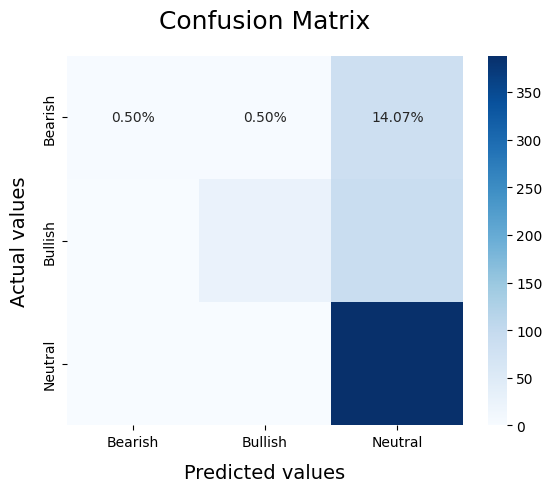

In [49]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_tfidf, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test_tfidf)

**Plotting the ROC-AUC Curve for model-1**
--


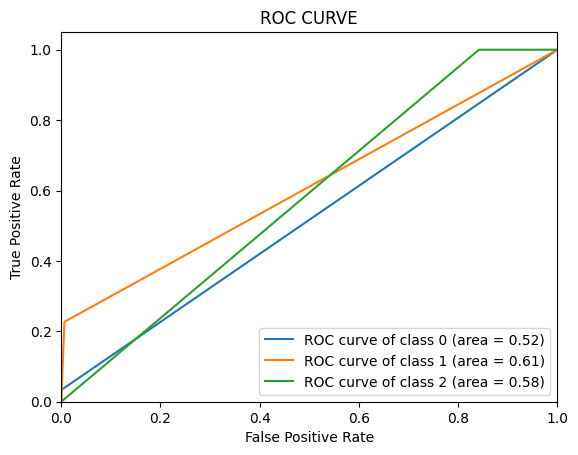

In [50]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Convert multiclass labels to binary labels using LabelBinarizer
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test)
y_pred1_binary = lb.transform(y_pred1)

# Compute ROC curve for each class
n_classes = len(lb.classes_)
roc_auc = dict()
fpr = dict()
tpr = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred1_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class %d (area = %0.2f)' % (i, roc_auc[i]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

**Model-2: SVM**
--

              precision    recall  f1-score   support

           0       0.72      0.53      0.61        90
           1       0.77      0.76      0.76       119
           2       0.87      0.93      0.90       388

    accuracy                           0.83       597
   macro avg       0.79      0.74      0.76       597
weighted avg       0.83      0.83      0.83       597



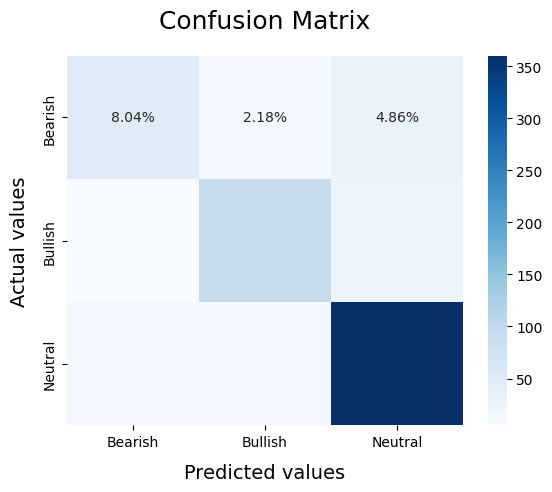

In [52]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train_tfidf, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test_tfidf)

**Plotting the ROC-AUC Curve for model-2**
---

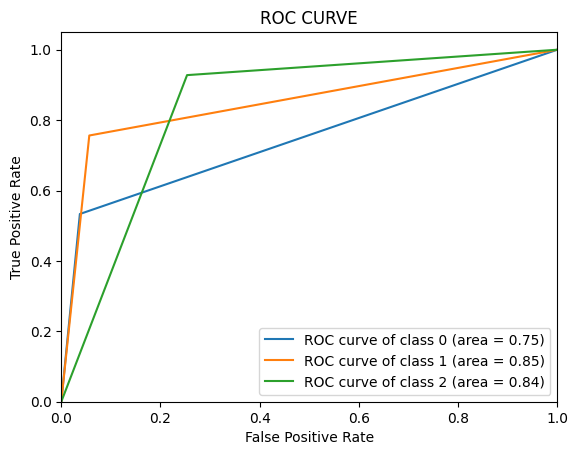

In [54]:

# Convert multiclass labels to binary labels using LabelBinarizer
lb2 = LabelBinarizer()
y_test_binary2 = lb2.fit_transform(y_test)
y_pred2_binary = lb2.transform(y_pred2)

# Compute ROC curve for each class
n_classes2 = len(lb2.classes_)
roc_auc2 = dict()
fpr2 = dict()
tpr2 = dict()
for i in range(n_classes):
    fpr2[i], tpr2[i], _ = roc_curve(y_test_binary2[:, i], y_pred2_binary[:, i])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])

# Plot ROC curves for each class
plt.figure()
for i in range(n_classes2):
    plt.plot(fpr2[i], tpr2[i], label='ROC curve of class %d (area = %0.2f)' % (i, roc_auc2[i]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

**Model Evaluation**
----

Upon evaluating all the models, we can conclude the following details i.e.

Accuracy: As far as the accuracy of the model is concerned, SVM, performs better than Bernoulli Naive Bayes.

F1-score: The F1 Scores for class 0 and class 1 are :
(a) For class 0: Bernoulli Naive Bayes(accuracy = 0.06) <<< SVM (accuracy =0.61) 
(b) For class 1: Bernoulli Naive Bayes (accuracy = 0.36) << SVM (accuracy = 0.76) 
(c) For class 2: Bernoulli Naive Bayes (accuracy = 0.82) < SVM (accuracy = 0.90) 

AUC Score: SVM clearly delivers better ROC-AUC score as we see in the ROC-curve.

We, therefore, conclude that the SVM is the better model for the above-given dataset.